In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df = pd.read_json("model/fake_news_reddit_cikm20.json")
df = df[df.researched_by != 'politifact']
df.info()
df.shape
df.head(10)
df.index = range(67936)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67936 entries, 0 to 69395
Data columns (total 6 columns):
label              67936 non-null int64
reddit_comments    67936 non-null object
researched_by      67936 non-null object
text               67936 non-null object
title              67936 non-null object
url                67936 non-null object
dtypes: int64(1), object(5)
memory usage: 3.6+ MB


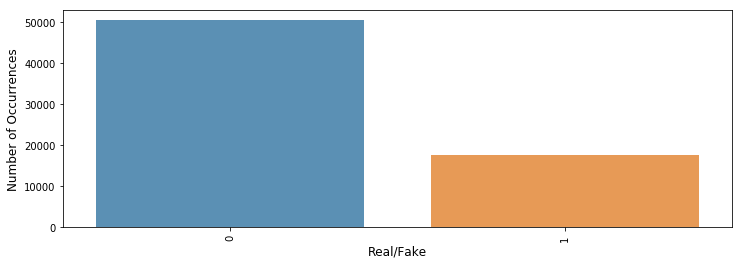

In [7]:
cnt_pro = df['label'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Real/Fake', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [9]:
def cleanText(text):
    text = re.sub(r'http\S+', r'<URL>', text)
    return text

In [10]:
df['text'] = df['text'].apply(cleanText)

In [13]:
from gensim.models import doc2vec
from nltk.tokenize import RegexpTokenizer
# Create a reference variable for Class RegexpTokenizer 
tk = RegexpTokenizer('\s+', gaps = True)
from nltk import PorterStemmer
from nltk.stem.porter import *

#lem = WordNetLemmatizer()
stemmer = PorterStemmer()
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the complaint narrative.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        text = tk.tokenize(v)
        text = [stemmer.stem(word) for word in text]
        labeled.append(doc2vec.TaggedDocument(text, [label]))
    return labeled

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, random_state=0, test_size=0.2)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [77]:
len(all_data)

67936

In [78]:
all_data[:10]

[TaggedDocument(words=['fruit', 'brute', '19751983', 'yummy', 'mummy', '19871993', 'breakfast', 'important', 'meal', 'day', 'told', 'grew', 'christen', 'golden', 'age', 'breakfast', 'cereal', 'large', 'variety', 'sugar', 'laced', 'option', 'choose', 'from', 'choose', 'did', 'fan', 'many', 'cereal', 'guess', 'thankful', 'parent', 'limit', 'option', 'mixture', 'sugar', 'grain', 'corn', 'fair', 'game', 'marshmallow', 'better', 'long', 'tasted', 'good', 'sometimes', 'even', 'but', 'lesson', 'go', 'good', 'thing', 'must', 'come', 'end', 'time', 'passed', 'product', 'fell', 'wayside', 'make', 'room', 'latest', 'product', 'sugarblasted', 'flavor', 'snazzy', 'box', 'art', 'maybe', 'cereal', 'got', 'lost', 'shuffle', 'assembly', 'line', 'drawn', 'close', 'mean', 'cereal', 'forgotten', 'memory', 'still', 'fond', 'least', 'fond', 'sugar', 'high', 'waxing', 'nostalgic', 'pay', 'tribute', 'sweet', 'breakfast', 'addiction', 'psychedelic', 'ad', 'campaign', 'research', 'find', 'good', 'news', 'howeve

# DBOW
DBOW is the Doc2Vec model analogous to Skip-gram model in Word2Vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

Training a Doc2Vec model is rather straight forward in Gensim, we initialize the model and train for 30 epochs:

dm =0 means ‘distributed bag of words’ (DBOW), set min_count=2 means ignoring all words with total frequency lower than this, size=100 is dimensionality of the generated feature vectors, alpha=0.025 is the initial alpha rate, learning rate will linearly drop to min_alpha as training progresses. And then we build a vocabulary.

In [92]:
model_dbow = Doc2Vec(dm=0, vector_size=256, window_size=20, negative=10, min_count=5, alpha=0.01, min_alpha=0.01, epochs=1)

In [93]:
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 67936/67936 [00:00<00:00, 602816.73it/s]


In [94]:
model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=50)

#%%time
#for epoch in range(50):
#    model_dbow.alpha -= 0.002
#    model_dbow.min_alpha = model_dbow.alpha

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 67936/67936 [00:00<00:00, 1064193.66it/s]


In [31]:
#model_dbow.save('d2v_model_dbow.doc2vec_2')
model_dbow = Doc2Vec.load('d2v_model_dbow.doc2vec_2')

In [32]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [33]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [35]:
from sklearn.linear_model import LogisticRegressionCV

logreg = LogisticRegressionCV(solver='liblinear', multi_class='ovr', class_weight='balanced')
logreg.fit(train_vectors_dbow, y_train)

c:\python3.7.3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LogisticRegressionCV(Cs=10, class_weight='balanced', cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='liblinear', tol=0.0001, verbose=0)

In [36]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
predictions = logreg.predict(test_vectors_dbow)
print(
"Accuracy:", accuracy_score(y_test,predictions),
"\nPrecision:", precision_score(y_test,predictions),
"\nRecall:", recall_score(y_test,predictions),
"\nF1:", f1_score(y_test,predictions))

Accuracy: 0.6114954371504269 
Precision: 0.3557983193277311 
Recall: 0.5941622228459164 
F1: 0.4450751603069484


Text(91.68, 0.5, 'Predicted label')

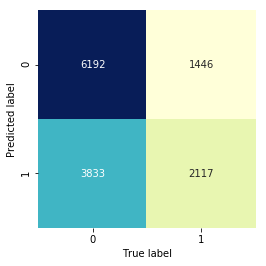

In [37]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, predictions)
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
sns.heatmap(mat.T, ax=ax, fmt="d", square=True, annot=True, cbar=False, cmap="YlGnBu")
ax.set_xlabel("True label")
ax.set_ylabel("Predicted label")

In [87]:
from sklearn.dummy import DummyClassifier
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(train_vectors_dbow, y_train)

accuracy_score(y_test,dummy_model.predict(X_test))
predictions = dummy_model.predict(test_vectors_dbow)
accuracy_score(y_test,predictions)

0.7377833382396232